Before starting, let's import some RooFit stuff.

In [1]:
from ROOT import RooGaussian
from ROOT import RooExponential
from ROOT import RooProdPdf
from ROOT import RooExtendPdf
from ROOT import RooFit
from ROOT import RooRealVar
from ROOT import RooAddPdf
from ROOT import RooArgList
from ROOT import RooArgSet
import ROOT
ROOT.SetMemoryPolicy(ROOT.kMemoryStrict)
import ROOT

def destruct_object(object_):
    """Destruct an object inheriting from TObject.

    See http://root.cern.ch/download/doc/ROOTUsersGuideHTML/ch19.html#d5e27551
    for more details

    provided by @apuignav

    :param object_: object to delete
    :type object_: TObject

    """
    if issubclass(type(object_), ROOT.TObject):
        object_.IsA().Destructor(object_)

Welcome to JupyROOT 6.07/03


Set up matplotlib for additional drawings. [See this blog for further information](http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/).

In [2]:
%pylab inline
plt.xkcd()

Populating the interactive namespace from numpy and matplotlib


In [3]:
bdt      = RooRealVar("BDT","some awesome BDT",0.,1.)
mass     = RooRealVar("mass","invariant mass",5100.,5300,"MeV/c^{2}")
time     = RooRealVar("time","decay time",0.,10,"ps")
sy_start = 100.
by_start = 900.
sy_min = 0.
by_min = 0.
sy_max = 100000.
by_max = 100000.

time_central = -1./1.519
time_min     = -1./0.200
time_max     = -1./9.200

sigyield = RooRealVar("sigyield","signal yield",sy_start,sy_min,sy_max)
bkgyield = RooRealVar("bkgyield","background yield",by_start,by_min,by_max)

blifetime= RooRealVar("blifetime","B meson lifetime",time_central,time_min,time_max)


bmassPDF = RooGaussian("bmass","B mass shape",mass,RooFit.RooConst(5200.),RooFit.RooConst(20.))
btimePDF = RooExponential("btime","B time shape",time,blifetime)
bkgmPDF  = RooExponential("bkgmass","bkg mass shape",mass,RooFit.RooConst(-1./200.))
bkgtPDF  = RooExponential("bbktime","bkg time shape",time,RooFit.RooConst(-1./0.200))
bdtsPDF  = RooExponential("bdts","sig bdt shape",bdt,RooFit.RooConst(0.))
bdtbPDF  = RooExponential("bdtb","bkg bdt shape",bdt,RooFit.RooConst(-3.))
sigfitpdf= RooProdPdf("sigfitpdf","signal fit pdf",bmassPDF,btimePDF)
bkgfitpdf= RooProdPdf("bkgfitpdf","background fit pdf",bkgmPDF,bkgtPDF)
Esigfitpdf=RooExtendPdf("Esigfitpdf","extended signal fit pdf",sigfitpdf,sigyield)
Ebkgfitpdf=RooExtendPdf("Ebkgfitpdf","extended background fit pdf",bkgfitpdf,bkgyield)
fitPDF   = RooAddPdf("fitpdf","mass and time pdf",RooArgList(Esigfitpdf,Ebkgfitpdf))
sigPDF   = RooProdPdf("sigpdf","signal pdf",RooArgList(bmassPDF,bdtsPDF,btimePDF))
bkgPDF   = RooProdPdf("bkgpdf","background pdf",RooArgList(bkgmPDF,bdtbPDF,bkgtPDF))
EsigPDF  = RooExtendPdf("Esigpdf","extended signal pdf",sigPDF,sigyield)
EbkgPDF  = RooExtendPdf("Ebkgpdf","extended background pdf",bkgPDF,bkgyield)
combPDF  = RooAddPdf("fullpdf","full pdf",RooArgList(EsigPDF,EbkgPDF))
EmsigPDF = RooExtendPdf("Emsigpdf","extended signal mass pdf",bmassPDF,sigyield)
EmbkgPDF = RooExtendPdf("Embkgpdf","extended background mass pdf",bkgmPDF,bkgyield)
combmPDF = RooAddPdf("fullmasspdf","full mass pdf",RooArgList(EmsigPDF,EmbkgPDF))

The models I try to set up are a Gaussian mass peak for the signal and exponential background. In decay time the signal is long lived, the background short lived. In BDT, the signal is uniform, the background exponential.

Lets look at a small toy where a cut on the BDT cleans up the decay time spectrum.

[#1] INFO:Plotting -- RooPlot::updateFitRangeNorm: New event count of 2129 will supercede previous event count of 10000 for normalization of PDF projections


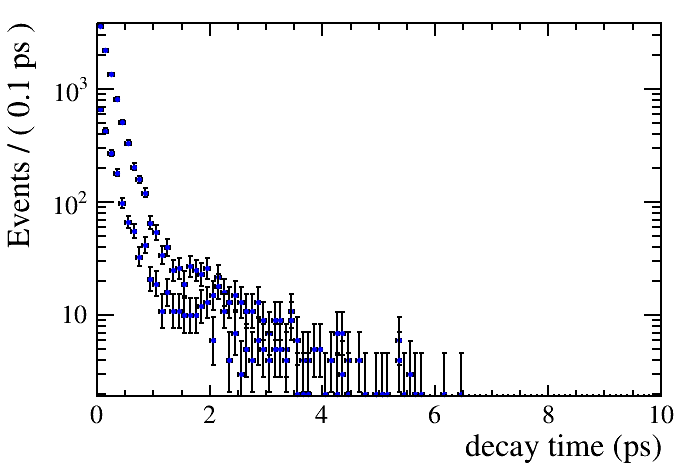

In [4]:
SIMEVTS = 10000#0
NTOYS = 1000
truesigyield = SIMEVTS*(sigyield.getVal()/(sigyield.getVal()+bkgyield.getVal()))
def gentoy():
    toydata = combPDF.generate(RooArgSet(bdt,mass,time),SIMEVTS)
    return toydata
toydata = gentoy()
from ROOT import TCanvas, RooCmdArg
from ROOT.RooFit import Cut
c = TCanvas()
frame = time.frame()
toydata.plotOn(frame)
smalldata = toydata.reduce(Cut("BDT>0.5"))
smalldata.plotOn(frame)#,Cut("BDT>0.5"))
frame.Draw()
c.SetLogy()
c.Draw()
destruct_object(toydata)
destruct_object(smalldata)

For automisation, a few helper functions: resetting fit parameters, fitting the toy data (with possible cut on the BDT - the efficiency for the signal as function of cut value is perfectly known, as well as the true signal expected yield), determination of pull in yield and bias.

For each toy, a scan over BDT cut values is performed (in steps of 0.1) to pick the best cut value (this is the one with the smallest uncertainty on the signal yield, fitting the invariant mass distribution).

The full fit to determine the lifetime, is an sFit. This means, the invariant mass spectrum is fitted, then all non-yield parameters are fixed and the yields are fitted again. As function of the invariant mass (using the fitted mass pdfs, and the covariance matrix of the fitted yields) weights are assigned, which parametrise how likely an event is signal or background, such that effectively the sum of all weights for background events sum up to 0 (such that backgrounds don't have an effect on the next fit). The weighted decay time is then fitted with only the signal component of the decay time distribution.

Generally, people don't fully trust the error estimates of sFits and therefore recommend using the bootstrap method to estimate the statistical uncertainty of the fit result. I don't do that here as I claim this is not relevant in my toys. See below the lifetime pulls for the scenarios w/o cut and with fixed cut. The bias is much smaller than in the optimised fit scenario.

In [5]:
from ROOT import RooMsgService
RooMsgService.instance().setGlobalKillBelow(RooFit.WARNING)
def reset():
    bkgyield.setMin(by_min)
    bkgyield.setMin(by_min)
    bkgyield.setMax(by_max)
    bkgyield.setMax(by_max)
    bkgyield.setVal(by_start)
    sigyield.setMin(sy_min)
    sigyield.setMin(sy_min)
    sigyield.setMax(sy_max)
    sigyield.setMax(sy_max)
    sigyield.setVal(sy_start)
    blifetime.setVal(time_central)
    blifetime.setMin(time_min)
    blifetime.setMax(time_max)

to_be_deleted = []

def fitwithcut(dataset,cutvalue):
    global to_be_deleted
    #print "full fit"
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    #smalldata.Print("V")
    #print "fit mass"
    combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(3),RooFit.PrintLevel(-1000))
    from ROOT.RooStats import SPlot
    #print "call splot"
    splot = SPlot("splot","splot",smalldata,combmPDF,RooArgList(sigyield,bkgyield))#,RooArgSet(),True,True)
    from ROOT import RooDataSet
    #print "do dataset stuff"
    sdata = RooDataSet("newdata","newdata",smalldata,smalldata.get(),"","sigyield_sw")
    #print "do sfit"
    btimePDF.fitTo(sdata,RooFit.Save(False),RooFit.NumCPU(3),RooFit.PrintLevel(-1000),RooFit.SumW2Error(True))
    #to_be_deleted.append(smalldata)
    #to_be_deleted.append(sdata)
    
    val, err = sigyield.getVal(),sigyield.getError()
    tval, terr = blifetime.getVal(),blifetime.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se,tval,terr

def fitonlymasswithcut(dataset,cutvalue):
    #print "fit mass"
    reset()
    smalldata = dataset.reduce(Cut("BDT>"+str(cutvalue)))
    #print "fit mass"
    fitres = combmPDF.fitTo(smalldata,RooFit.Save(False),RooFit.NumCPU(3),RooFit.PrintLevel(-1000))
    #fitres.Print("V")
    destruct_object(smalldata)
    val, err = sigyield.getVal(),sigyield.getError()
    sy = val/(1.-cutvalue)
    se = err/(1.-cutvalue)
    return sy,se
                            

def runtoy():
    reset()
    toydata = gentoy()
    RooMsgService.instance().setGlobalKillBelow(RooFit.ERROR)
    cutval = 0.0
    sy,se,tc,te = fitwithcut(toydata,cutval)
    
    res = sy-truesigyield
    pull = res/se
    
    cutval = 0.5
    sy2,se2,tc2,te2 = fitwithcut(toydata,cutval)
    res2 = sy2-truesigyield
    pull2 = res2/se2
    
    tv = 0.0
    bestcut = tv
    by,be = fitonlymasswithcut(toydata,tv)
    # TO optimise the mass cut, we do not want to use the time dimension!
    for tv in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
        y,e = fitonlymasswithcut(toydata,tv)
        if e/y <= be/by:
            by,be = y,e
            bestcut = tv
    delme,delmetoo,timebest,timeerror = fitwithcut(toydata,bestcut)
    resbest = by-truesigyield
    pullbest = resbest/be
    for x in to_be_deleted:
        destruct_object(x)
    return res,pull,res2,pull2, resbest,pullbest,(tc,te,tc2,te2,timebest,timeerror)
    

Now, run many toys, record the pulls and residuals for "no cut", "cut at 0.5", and "best cut".

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

   INFO: In dommap (/home/pseyfert/coding/ROOT6/roofit/roofitcore/src/BidirMMapPipe.cxx, line 422): anonymous mmapping works, excellent!


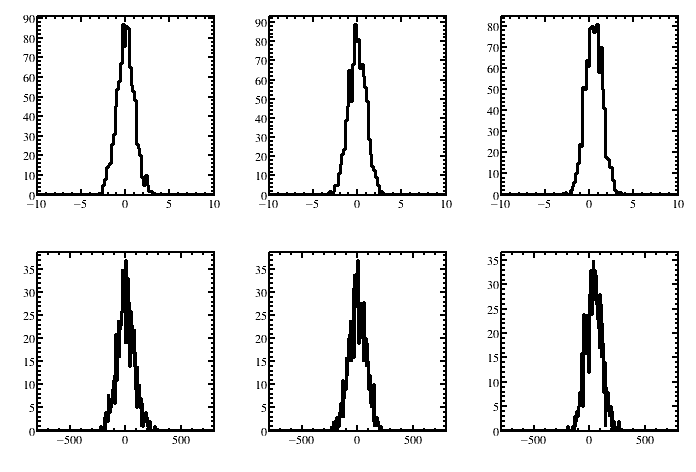

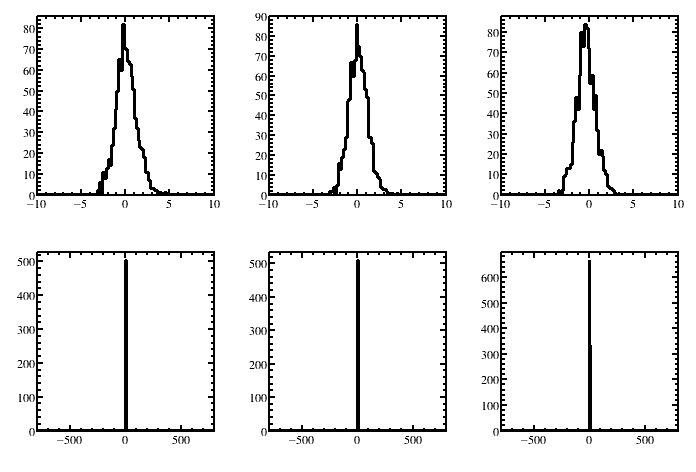

In [6]:
from ROOT import TH1F, RooRandom
pullhist = TH1F("pullhist","pulls without BDT cut",100,-10,10)
pull2hist = TH1F("pull2hist","pulls with BDT cut",100,-10,10)
pullbhist = TH1F("pullbhist","pulls with best BDT cut",100,-10,10)
reshist = TH1F("reshist","residuals without BDT cut",300,-800,800)
res2hist = TH1F("res2hist","residuals with BDT cut",300,-800,800)
resbhist = TH1F("resbhist","residuals with best BDT cut",300,-800,800)

timepullhist = TH1F("timepullhist","time pulls without BDT cut",100,-10,10)
timepull2hist = TH1F("timepull2hist","time pulls with BDT cut",100,-10,10)
timepullbhist = TH1F("timepullbhist","time pulls with best BDT cut",100,-10,10)
timereshist = TH1F("timereshist","time residuals without BDT cut",300,-800,800)
timeres2hist = TH1F("timeres2hist","time residuals with BDT cut",300,-800,800)
timeresbhist = TH1F("timeresbhist","time residuals with best BDT cut",300,-800,800)

for i in xrange(NTOYS):
    print ".",
    RooRandom.randomGenerator().SetSeed(i)
    #res,pull,timestuff = runtoy()
    res,pull,res2,pull2,resb,pullb,timestuff = runtoy()
    pullhist.Fill(pull)
    pull2hist.Fill(pull2)
    pullbhist.Fill(pullb)
    reshist.Fill(res)
    res2hist.Fill(res2)
    resbhist.Fill(resb)
    timereshist.Fill(timestuff[0]-time_central)
    timepullhist.Fill((timestuff[0]-time_central)/timestuff[1])
    timeres2hist.Fill(timestuff[2]-time_central)
    timepull2hist.Fill((timestuff[2]-time_central)/timestuff[3])
    timeresbhist.Fill(timestuff[4]-time_central)
    timepullbhist.Fill((timestuff[4]-time_central)/timestuff[5])
cc = TCanvas()
cc.Divide(3,2)
cc.cd(1)
pullhist.Draw()
cc.cd(2)
pull2hist.Draw()
cc.cd(3)
pullbhist.Draw()
cc.cd(4)
reshist.Draw()
cc.cd(5)
res2hist.Draw()
cc.cd(6)
resbhist.Draw()
cc.Draw()
ccc = TCanvas()
ccc.Divide(3,2)
ccc.cd(1)
timepullhist.Draw()
ccc.cd(2)
timepull2hist.Draw()
ccc.cd(3)
timepullbhist.Draw()
ccc.cd(4)
timereshist.Draw()
ccc.cd(5)
timeres2hist.Draw()
ccc.cd(6)
timeresbhist.Draw()
ccc.Draw()


Let's have a look. The scenario "no cut" and the scenario with the fixed cut seem unbiased. But when always picking the best cut value, on seems to be off by 15 σ!

In [7]:
print "resolution without cut is        ", reshist.GetRMS()
print "bias without cut is              ", pullhist.GetMean(), u"±", pullhist.GetMeanError()
print "resolution with cut at 0.5 is    ", res2hist.GetRMS()
print "bias with cut at 0.5 is          ", pull2hist.GetMean(), u"±", pull2hist.GetMeanError()
print "resolution with optimised cut is ", resbhist.GetRMS()
print "bias with optimised cut is       ", pullbhist.GetMean(), u"±", pullbhist.GetMeanError()


resolution without cut is         76.8117797625
bias without cut is               -0.0191003125081 ± 0.0315207382092
resolution with cut at 0.5 is     75.9204427649
bias with cut at 0.5 is           -0.0650277059721 ± 0.0313071097896
resolution with optimised cut is  71.0488744037
bias with optimised cut is        0.470829676847 ± 0.0299706950779


What happened? Well, in optimising the yield, we picked BDT cuts for which the background fluctuates upwards (in the most simple interpretation. The RooFit model does not retain information about which events are signal and which are background, but you can assume the mass spectrum to look like this. NB: If no cut value exists for which the background fluctuates up at the right position, then, well we'll just get a values for which it doesn't fluctuate down. Or maybe even the cut value which leads to the best signal significance! (We can't disentangle optimisation from fluctuation in this setup.)

The sPlot method then picks these additional background events up in the signal component, such that we have still background when using sWeights in the sFit.

And then a bit of other setups for drawings. [See this blog](http://jakevdp.github.io/blog/2013/07/10/XKCD-plots-in-matplotlib/) for more information.

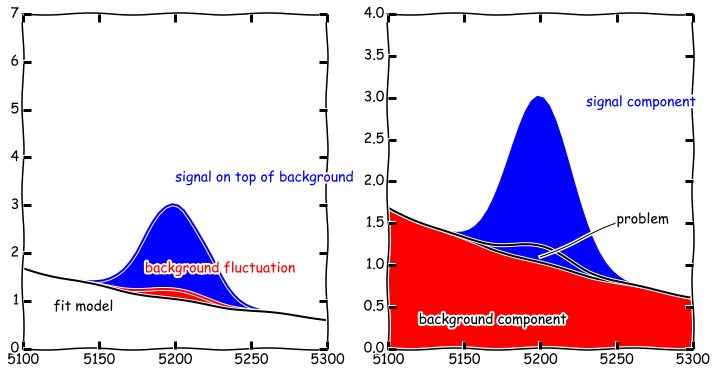

In [8]:
def signal(x):
    return 1e8*matplotlib.mlab.normpdf(x,5200,20)
def exponential(x):
    return 2e8*1000.*math.exp(-x/200.)
def background_with_fluctuation(x):
    return 0.0000001*signal(x)+exponential(x)
def both(x):
    return 0.000001*signal(x)+exponential(x)
X = linspace(5100,5300)
fig,axs = plt.subplots(1,2,figsize=(12,6),frameon=False)
ax = axs[0]
#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111)
ax.set_xlim(5100,5300)
ax.set_ylim(0, 7)
#ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%i%%'))

ax.plot(X,[both(x) for x in X],color='blue')
ax.plot(X,[background_with_fluctuation(x) for x in X],color='red')
ax.plot(X,[exponential(x) for x in X],color='black')
ax.fill_between(X,[exponential(x) for x in X],[background_with_fluctuation(x) for x in X],color='red')
ax.fill_between(X,[background_with_fluctuation(x) for x in X],[both(x) for x in X],color='blue')
ax.text(5120,0.8,"fit model",color='black')
ax.text(5180,1.6,"background fluctuation",color='red')
ax.text(5200,3.5,"signal on top of background",color='blue')

ax = axs[1]
ax.set_xlim(5100,5300)
ax.set_ylim(0, 4)
#ax.plot(X,[both(x) for x in X],color='blue')
ax.plot(X,[exponential(x) for x in X],color='black')
ax.fill_between(X,[0. for x in X],[exponential(x) for x in X],color='red')
ax.fill_between(X,[exponential(x) for x in X],[both(x) for x in X],color='blue')
ax.plot(X,[background_with_fluctuation(x) for x in X],color='black')
ax.plot([5200,5250],[1.1,1.5],'-k',lw=1,color='black')
#ax.text(5120,0.8,"fit model",color='black')
ax.text(5120,0.3,"background component",color='black')
ax.text(5230,2.9,"signal component",color='blue')
ax.text(5250,1.5,"problem",color="black")

Lets look at what happens in the sFit.

In [9]:
print "time resolution without cut is        ", timereshist.GetRMS()
print "time bias without cut is              ", timepullhist.GetMean(), u"±", timepullhist.GetMeanError()
print "time resolution with cut at 0.5 is    ", timeres2hist.GetRMS()
print "time bias with cut at 0.5 is          ", timepull2hist.GetMean(), u"±", timepull2hist.GetMeanError()
print "time resolution with optimised cut is ", timeresbhist.GetRMS()
print "time bias with optimised cut is       ", timepullbhist.GetMean(), u"±", timepullbhist.GetMeanError()


time resolution without cut is         0.047875004514
time bias without cut is               0.0658157332208 ± 0.0368912471495
time resolution with cut at 0.5 is     0.0483923788646
time bias with cut at 0.5 is           0.0593840248424 ± 0.0344864691467
time resolution with optimised cut is  0.0448867199598
time bias with optimised cut is        -0.39688233788 ± 0.0339132279737


Apparently, the sFit is not perfect. The fit w/o cut and with fixed cut have a bias of 6% of the statistical error estimate at 2σ significance. Yet, the optimised cut scenario is far worse, a 12σ significant bias of 40% of the statistical error.